In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit as cf
from sklearn import preprocessing as prep


In [13]:
c = 299792458
h = 6.626e-34
kB = 1.38e-23
T = 8
gs = 63e9
boltzmann = np.exp(-h*gs/(kB*T))
boltzmann

0.6851522994735559

In [32]:
Gamma_pht = 1/(2*np.pi*1.7)
Gamma_phn = 1/(2*np.pi*46)
Gamma_spin = 1/(2*np.pi*170)

eta = 0.25
OmegaC3 = 25/2*Gamma_pht
OmegaC1 = np.sqrt(eta)*OmegaC3

In [33]:
a1 = basis(5,0)
a2 = basis(5,1)
b1 = basis(5,2)
b2 = basis(5,3)
c = basis(5,4)

HintC1 = OmegaC1/2*(a1*c.dag() + c*a1.dag()) 
HintC3 = OmegaC3/2*(a2*c.dag() + c*a2.dag())

Gamma_c = np.sqrt(Gamma_pht)*(eta*(b1+a1)+b2+a2)*c.dag()

Gamma_a1 = (np.sqrt(Gamma_spin)*a2 + np.sqrt(boltzmann*Gamma_phn)*b1)*a1.dag()
Gamma_a2 = (np.sqrt(Gamma_spin)*a1 + np.sqrt(boltzmann*Gamma_phn)*b2)*a2.dag()

Gamma_b1 = (np.sqrt(Gamma_spin)*b2+np.sqrt(Gamma_phn)*a1)*b1.dag()
Gamma_b2 = (np.sqrt(Gamma_spin)*b1+np.sqrt(Gamma_phn)*a2)*b2.dag()

c_ops = [Gamma_c, Gamma_a1, Gamma_a2, Gamma_b1, Gamma_b2]

def seqC3(t, args):    
    return np.where( (t>args['tstart']) & (t<args['tstart']+args['pulsewidth']), 1, 0)
    

C:\Program Files (x86)\Python36\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


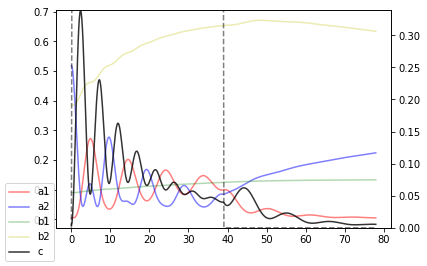

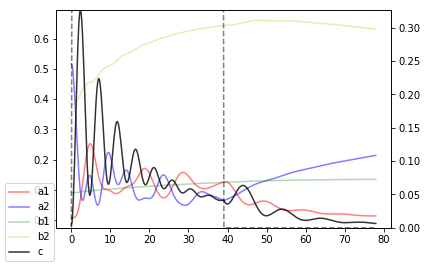

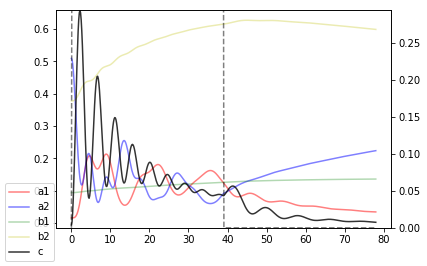

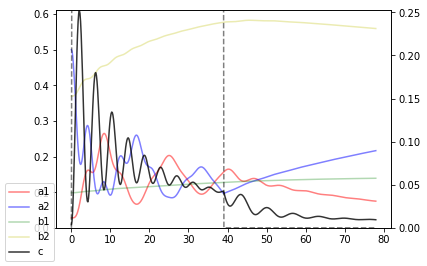

In [34]:
deltas = np.arange(0,1,0.05)
pulsewidths = np.arange(20,40,0.05)
peak_heights = np.zeros((len(deltas),len(pulsewidths)))
for i, delta in enumerate(deltas):
    for j, pulsewidth in enumerate(pulsewidths):
        deltaC1 = delta
        deltaC3 = deltaC1
        Hsys = (deltaC1-deltaC3)*a2*a2.dag() + deltaC3*c*c.dag()
        H = [Hsys+HintC1, [HintC3, seqC3]]

        rho0 = a1*a1.dag() + a2*a2.dag() + boltzmann*(b1*b1.dag() + b2*b2.dag())
        rho0 = rho0/rho0.tr()
        rho0 = steadystate(Hsys+HintC1, c_ops)
        e_ops = [a1*a1.dag(), a2*a2.dag(), b1*b1.dag(), b2*b2.dag(), c*c.dag()]

        tstart = 0
        pulsewidth = pulsewidth
        tmax = tstart + 2*pulsewidth
        pulse_args = {'tstart':tstart, 'pulsewidth':pulsewidth}
        t = np.linspace(0, tmax, 5e2)
        
        output = mesolve(H, rho0, t, c_ops=c_ops, e_ops=e_ops, args=pulse_args)
        cts = output.expect[4]
        
        peak_heights[i,j] = cts[np.argmin(np.abs(t-(tstart+pulsewidth)))+1]

    if i%5==0:
        fig = plt.figure()
        ax = fig.gca()
        ax.plot(t, output.expect[0], '-r', label='a1', alpha=0.5)
        ax.plot(t, output.expect[1], '-b', label='a2', alpha=0.5)
        ax.plot(t, output.expect[2], '-g', label='b1', alpha=0.3)
        ax.plot(t, output.expect[3], '-y', label='b2', alpha=0.3)
        
        ax2 = ax.twinx()
        ax2.plot(t, cts, '-k', label='c', alpha=0.8)
        ax2.plot(t, seqC3(t, pulse_args)*max(np.amax(output.expect[0]),np.amax(output.expect[1])), '--k', alpha=0.5)
        ax2.set_ylim([0, np.amax(cts)])
        # ax2.set_yticks([])
        # ax2.set_yticklabels([])
        fig.legend(loc='lower left')
        plt.show()

In [36]:
rho0

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[ 4.06579244e-02+0.00000000e+00j  1.30777365e-04+9.10928324e-04j
   3.41567289e-05+2.27321674e-04j  1.64929396e-03+1.09764686e-02j
  -1.13032084e-02+1.20319939e-03j]
 [ 1.30777365e-04-9.10928324e-04j  4.90285216e-01+0.00000000e+00j
   2.06313772e-01+0.00000000e+00j  8.60217537e-02+0.00000000e+00j
  -1.02959228e-05+2.81627605e-04j]
 [ 3.41567289e-05-2.27321674e-04j  2.06313772e-01+0.00000000e+00j
   1.03690492e-01+0.00000000e+00j  1.88409490e-02+0.00000000e+00j
  -2.99254862e-06+7.03267824e-05j]
 [ 1.64929396e-03-1.09764686e-02j  8.60217537e-02+0.00000000e+00j
   1.88409490e-02+0.00000000e+00j  3.61827546e-01+0.00000000e+00j
  -1.44498391e-04+3.39580343e-03j]
 [-1.13032084e-02-1.20319939e-03j -1.02959228e-05-2.81627605e-04j
  -2.99254862e-06-7.03267824e-05j -1.44498391e-04-3.39580343e-03j
   3.53882173e-03+0.00000000e+00j]]

4.284150279104936 4.481193287306568


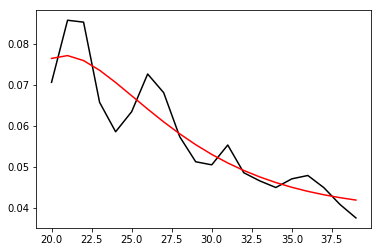

In [35]:
x = pulsewidths
y = peak_heights[0,:]

ramsey_fit = lambda t, a, Omega, Gamma, phi, c: a*np.exp(-Gamma*t)*np.cos(Omega*t+phi) + c
p0 = np.amax(y), (OmegaC1+OmegaC3)/(2*delta), 1/100, 0, y[-1]
popt, pcov = cf(ramsey_fit, x, y, p0=p0)
plt.plot(x, y, '-k')
plt.plot(x, ramsey_fit(x, *popt), '-r')
print(1/popt[2], 1/(2*np.pi*OmegaC3**2*Gamma_pht/(4*delta**2)))

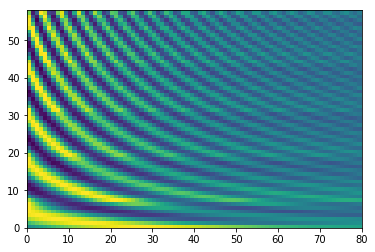

In [111]:
plt.pcolor(prep.maxabs_scale(peak_heights,axis=1))

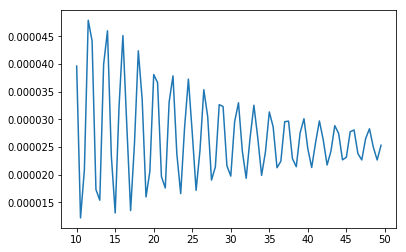

In [114]:
plt.plot(pulsewidths, peak_heights[-1,:])